# Übung 5: Backpropagation für Mehrschichtperzeptronen

In [1]:
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap
import pandas as pd
import random

np.set_printoptions(suppress=True, linewidth=np.inf)
sns.set_style("darkgrid")

%reload_ext version_information
%version_information numpy, seaborn, pandas, random, matplotlib

Software versions
Python 3.7.4 64bit [GCC 7.3.0]
IPython 7.8.0
OS Linux 4.15.0 72 generic x86_64 with debian buster sid
numpy 1.17.2
seaborn 0.9.0
pandas 0.25.1
random The 'random' distribution was not found and is required by the application
matplotlib 3.1.1
Mon Dec 16 15:21:29 2019 CET

In [2]:
def cost(ypred, y):
    if cost_method == "MSE":
        return (ypred - y)**2
    elif cost_method == "LOGREG":
        return -y * np.log(ypred) - ((1 - y) * np.log(1 - ypred))
    else:
        print("Unknown cost function.")
        exit(1)

def cost_derived(output_activations, y):
    if cost_method == "MSE":
        return (output_activations - y)
    elif cost_method == "LOGREG":
        dC = (-1*(output_activations - y)) / ((output_activations - 1) * output_activations)
        dC = np.nan_to_num(dC)
        return dC
    else:
        print("Unknown cost function.")
        exit(1)
    
def activation(z):
    if activation_method == "SIGMOID":
        return 1.0 / (1.0 + np.exp(-z))
    elif activation_method == "RELU":
        return np.maximum(0, z)
    elif activation_method == "TANH":
        return np.tanh(z)
    else:
        print("Unknown activation method.")
        exit(1)

def activation_derived(z):
    if activation_method == "SIGMOID":
        return sigmoid(z) * (1 - sigmoid(z))
    elif activation_method == "RELU":
        z[z <= 0] = 0
        z[z > 0] = 1
        return z
    elif activation_method == "TANH":
        return 1 - (np.tanh(z) * np.tanh(z))
    else:
        print("Unknown activation function.")
        exit(1)
    
def feedforward(a, weights, biases):
    activations = [a]
    zs = []
    for weight, bias in zip(weights, biases):
        z = np.dot(weight, a) + bias
        a = activation(z)
        zs.append(z)
        activations.append(a)
    return np.asarray(activations), np.asarray(zs)

def get_biases_and_weights(layer_dims, fill="zeros", verbose=False):
    
    if fill == "zeros":
        new_biases = np.array([np.zeros(shape=(l, 1)) for l in layer_dims[1:]])
        new_weights = np.array([np.zeros(shape=(l1, l2)) for l1, l2 in zip(layer_dims[1:], layer_dims[:-1])])
    elif fill == "random":
        new_biases = np.array([np.random.rand(l, 1) for l in layer_dims[1:]])
        new_weights = np.array([np.random.rand(l1, l2) for l1, l2 in zip(layer_dims[1:], layer_dims[:-1])])
    else:
        print("Wrong fill type.")
    
    if verbose:
        print("bias dimensions: {}".format(layer_dims[1:]))
        print("weight dimensions: {}, {}".format(layer_dims[1:], layer_dims[:-1]))
        print()

        for i, bias in enumerate(new_biases):
            print("bias layer {}: \n {}".format(i+1, bias))
        print()

        for i, weight in enumerate(new_weights):
            print("weight layer {}: \n {}".format(i+1, weight))
        print()
    
    return new_biases, new_weights

def evaluate(x2, y2, weights, biases): 
    n = x2.shape[0]
    correct = 0
    mse_ = 0
    
    for i in range(0, n):
        x = np.asarray([x2[i]]).T
        y = np.asarray([y2[i]]).T
        ypred = feedforward(x, weights, biases)[0][-1]
        
        c = y[0]
        cpred = 0
        
        if activation_method == "TANH":
            thresh = 0.0
        else:
            thresh = 0.5
            
        if ypred > thresh:
            cpred = 1
        else:
            cpred = 0
            
        if cpred == c:
            correct += 1
            
        mse_ += cost(ypred, y[0])
        
    return correct / n, mse_

def backprop(x, y, weights, biases, layer_dims):
    nabla_b, nabla_w = get_biases_and_weights(layer_dims)
    
    activations, zs = feedforward(x, weights, biases)
    delta = cost_derived(activations[-1], y) * activation_derived(zs[-1])
    
    nabla_b[-1] = delta
    nabla_w[-1] = np.dot(delta, activations[-2].T)
    
    for l in range(2, len(layer_dims)):
        z = zs[-l]
        sp = activation_derived(z)
        t = np.dot(weights[-l+1].transpose(), delta)
        delta = t * sp
        nabla_b[-l] = delta
        nabla_w[-l] = np.dot(delta, activations[-l-1].T)
    
    return (nabla_b, nabla_w)

def update_mini_batch(xmb, ymb, eta, weights, biases, layer_dims):
    nabla_b, nabla_w = get_biases_and_weights(layer_dims)
    
    for i in range(xmb.shape[0]):
        x = np.reshape(xmb[i,:],(xmb.shape[1],1)).copy()
        y = ymb[i].copy()
        
        delta_nabla_b, delta_nabla_w = backprop(x, y, weights, biases, layer_dims)
        
        nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
    
    weights = [w-(eta/xmb.shape[0])*nw for w, nw in zip(weights, nabla_w)]
    biases = [b-(eta/xmb.shape[0])*nb for b, nb in zip(biases, nabla_b)]
    
    weights = np.asarray(weights)
    biases = np.asarray(biases)
    
    return (weights, biases)

def SGD(x0, y0, n_epochs, mini_batch_size, eta, x2, y2, split, layer_dims):

    biases, weights = get_biases_and_weights(layer_dims, fill="random")

    accuracys_test = np.zeros(shape=(n_epochs))
    accuracys_train = np.zeros(shape=(n_epochs))
    mses_test = np.zeros(shape=(n_epochs))
    mses_train = np.zeros(shape=(n_epochs))
    
    for epoch in range(n_epochs):
        
        mixer = list(zip(x0, y0))
        random.shuffle(mixer)
        x0, y0 = zip(*mixer)
        x0 = np.asarray(x0)
        y0 = np.asarray(y0)
        
        for k in range(0, x0.shape[0], mini_batch_size):
            xmb = x0[k:k+mini_batch_size,:]
            ymb = y0[k:k+mini_batch_size]
            weights, biases = update_mini_batch(xmb, ymb, eta, weights, biases, layer_dims)
        
        accuracys_test[epoch], mses_test[epoch] = evaluate(x2, y2, weights, biases)
        percent_test = accuracys_test[epoch] * 100
        
        accuracys_train[epoch], mses_train[epoch] = evaluate(x0, y0, weights, biases)
        percent_train = accuracys_train[epoch] * 100
        
        if (epoch % split) == 0:
            print("Epoch: {} / {}, Train-Accuracy: {:.4f}({:.2f}%), Test-Accuracy: {:.4f}({:.2f}%)".format(
                               epoch, n_epochs, 
                               accuracys_train[epoch], percent_train, 
                               accuracys_test[epoch], percent_test))
    
    return accuracys_test, mses_test, accuracys_train, mses_train, biases, weights

def generate_data(x_range, y_range, num):
    lx_range, ux_range = x_range
    ly_range, uy_range = y_range
    data = np.asarray([[np.random.uniform(lx_range, ux_range), np.random.uniform(ly_range, uy_range)] for i in range(num)])
    labels = []
    for i, point in enumerate(data):
        x, y = point
        if x < 0 and y < 0:
            labels.append(1)        
        elif x > 0 and y > 0:
            labels.append(1)        
        elif x > 0 and y < 0:
            labels.append(0)        
        else:
            labels.append(0)
    return data, np.asarray(labels)

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def perzeptron(x):
    weights = np.array([[0, 1], [1 , 0]])
    biases = np.array([[0], [0]])
    
    xt = np.zeros(shape=(len(x), 2))
    for j in range(len(weights)):
        xt[:, j] = [sigmoid((weights[j] @ x[i]) + biases[j]) for i in range(len(x))]
    return xt

def get_first_layer_grid(x0, y0):
    weights = np.asarray([[0.0, 1.0], [1.0, 0.0]])
    biases = np.asarray([[0], [0]])
    values = np.zeros(shape=(2, 100, 100))
    
    lo = np.round(np.min(x0))
    up = np.round(np.max(x0))
    
    xs = np.linspace(lo, up, 100)
    ys = np.linspace(lo, up, 100)

    for i in range(2):
        for xidx, x in enumerate(xs):
            for yidx, y in enumerate(ys):                   
                values[i, yidx, xidx] = sigmoid(np.dot(weights[i], np.array([x, y])) + biases[i].squeeze())
    return np.asarray(values)

def get_grid(x0, y0, weights, biases):
    values = np.zeros(shape=(2, 100, 100))
    
    lo = np.round(np.min(x0))
    up = np.round(np.max(x0))
    
    xs = np.linspace(lo, up, 100)
    ys = np.linspace(lo, up, 100)

    for i in range(2):
        for xidx, x in enumerate(xs):
            for yidx, y in enumerate(ys):                   
                values[i, yidx, xidx] = feedforward(np.array([np.array([x, y])]).T, weights, biases)[0][-1]
    return np.asarray(values)

def plot_grid(x0, y0, x2, y2, values):
    
    lo = np.round(np.min(x0))
    up = np.round(np.max(x0))
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))
    palette = sns.color_palette("viridis", 32)
    cmap = ListedColormap(sns.color_palette(palette).as_hex())

    axes[0].imshow(values[0], interpolation='none', cmap=cmap)
    axes[0].grid(color='w', linestyle='-', linewidth=0.5)
    axes[0].invert_yaxis()

    lo = np.round(np.min(x0))
    up = np.round(np.max(x0))
    
    x0_0 = x0[y0 == 0]
    x0_1 = x0[y0 == 1]
    x0_0_plot = (x0_0) * (100 / (np.abs(lo) + np.abs(up)))
    x0_1_plot = (x0_1) * (100 / (np.abs(lo) + np.abs(up)))
    sns.scatterplot(x=x0_0_plot[:, 0], y=x0_0_plot[:, 1], color='red', ax=axes[0], s=30)
    sns.scatterplot(x=x0_1_plot[:, 0], y=x0_1_plot[:, 1], color='blue', ax=axes[0], s=30)
    axes[0].set_title("Train data")

    pos_list = np.arange(0, 100, 99)
    value_list = np.arange(lo, up + 1, 1)
    axes[0].xaxis.set_major_locator(ticker.FixedLocator((pos_list)))
    axes[0].xaxis.set_major_formatter(ticker.FixedFormatter((value_list)))
    axes[0].yaxis.set_major_locator(ticker.FixedLocator((pos_list)))
    axes[0].yaxis.set_major_formatter(ticker.FixedFormatter((value_list)))


    axes[1].imshow(values[1], interpolation='none', cmap=cmap)
    axes[1].grid(color='w', linestyle='-', linewidth=0.5)
    axes[1].invert_yaxis()

    x2_0 = x2[y2 == 0]
    x2_1 = x2[y2 == 1]
    x2_0_plot = (x2_0) * (100 / (np.abs(lo) + np.abs(up)))
    x2_1_plot = (x2_1) * (100 / (np.abs(lo) + np.abs(up)))
    sns.scatterplot(x=x2_0_plot[:, 0], y=x2_0_plot[:, 1], color='red', ax=axes[1], s=30)
    sns.scatterplot(x=x2_1_plot[:, 0], y=x2_1_plot[:, 1], color='blue', ax=axes[1], s=30)
    axes[1].set_title("Test data")

    pos_list = np.arange(0, 100, 99)
    value_list = np.arange(lo, up + 1, 1)
    axes[1].xaxis.set_major_locator(ticker.FixedLocator((pos_list)))
    axes[1].xaxis.set_major_formatter(ticker.FixedFormatter((value_list)))
    axes[1].yaxis.set_major_locator(ticker.FixedLocator((pos_list)))
    axes[1].yaxis.set_major_formatter(ticker.FixedFormatter((value_list)));
    
def plot_stats(accuracys_test, mses_test, accuracys_train, mses_train):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
    sns.lineplot(x=np.linspace(0, len(accuracys_train), n_epochs), y=accuracys_train, ax=axes[0, 0])
    axes[0, 0].set_title("Train data")
    axes[0, 0].set_xlabel("epochs")
    axes[0, 0].set_ylabel("correct")

    sns.lineplot(x=np.linspace(0, len(accuracys_test), n_epochs), y=accuracys_test, ax=axes[0, 1], color='orange')
    axes[0, 1].set_title("Test data")
    axes[0, 1].set_xlabel("epochs")
    axes[0, 1].set_ylabel("correct")

    sns.lineplot(x=np.linspace(0, len(mses_train), n_epochs), y=mses_train, ax=axes[1, 0])
    axes[1, 0].set_title("Train data")
    axes[1, 0].set_xlabel("epochs")
    axes[1, 0].set_ylabel("mse")

    sns.lineplot(x=np.linspace(0, len(mses_test), n_epochs), y=mses_test, ax=axes[1, 1], color='orange')
    axes[1, 1].set_title("Test data")
    axes[1, 1].set_xlabel("epochs")
    axes[1, 1].set_ylabel("mse");

## 1. Spielzeugdatensatz

### 1.1) + 1.2) Generieren und labeln der Spielzeugdaten

In [3]:
x_range = (-6.0, 6.0)
y_range = (-6.0, 6.0)
num_data = 200

x0, y0 = generate_data(x_range, y_range, num_data)
x2, y2 = generate_data(x_range, y_range, num_data)

### 1.3) Plotten der Spielzeugdaten(train und test)

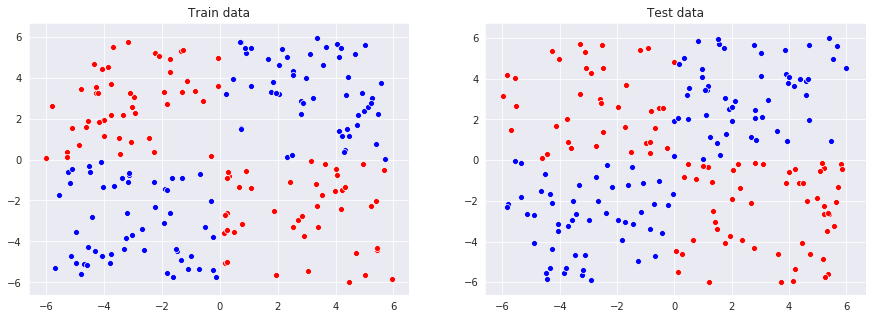

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

x0_0 = x0[y0 == 0]
x0_1 = x0[y0 == 1]
sns.scatterplot(x=x0_0[:, 0], y=x0_0[:, 1], color='red', ax=axes[0])
sns.scatterplot(x=x0_1[:, 0], y=x0_1[:, 1], color='blue', ax=axes[0])
axes[0].set_title("Train data")

x2_0 = x2[y2 == 0]
x2_1 = x2[y2 == 1]
sns.scatterplot(x=x2_0[:, 0], y=x2_0[:, 1], color='red', ax=axes[1])
sns.scatterplot(x=x2_1[:, 0], y=x2_1[:, 1], color='blue', ax=axes[1])
axes[1].set_title("Test data");

### 1.4) Neuronen für die ersten zwei Neuronen.

In [5]:
%%latex
Gewichte der Neuronen im Hidden Layer(Layer 2): 
\begin{align}
    w^{2}_{i1} = \begin{pmatrix} 0 \\ 1 \end{pmatrix}, b^{2}_{1} = 0  \\
    w^{2}_{i2} = \begin{pmatrix} 1 \\ 0 \end{pmatrix}, b^{2}_{2} = 0
\end{align}

<IPython.core.display.Latex object>

### 1.5) Entscheidungsfunktion der ersten zwei Neuronen im 100x100 Gitter

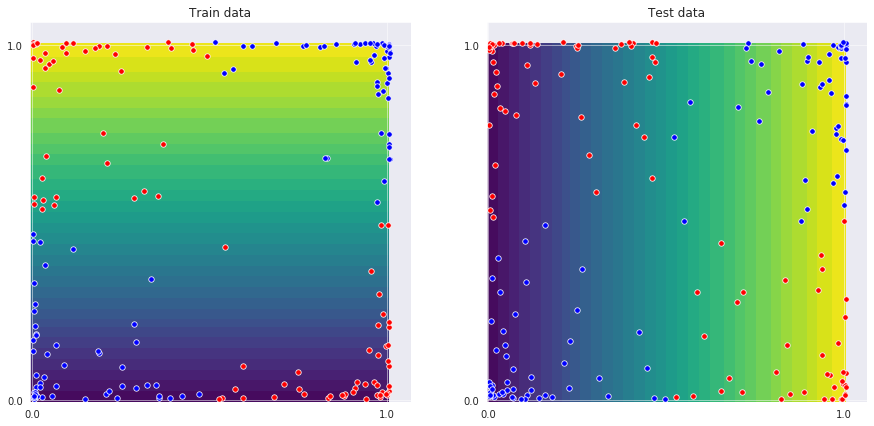

In [6]:
global activation_method
global cost_method
activation_method = "SIGMOID"
cost_method = "MSE"

x0 = perzeptron(x0)
x2 = perzeptron(x2)

values = get_first_layer_grid(x0, x2)
plot_grid(x0, y0, x2, y2, values)

### 1.6) Erste Neuronen auf Daten anwenden

In [7]:
mbs = 25
eta = 0.25
n_epochs = 2500
layer_dims = [2, 3, 1]
split = 100

## 2. Training eines MLPs auf den Spielzeugdaten

In [8]:
global activation_method
global cost_method
activation_method = "SIGMOID"
cost_method = "MSE"

accuracys_test, mses_test, accuracys_train, mses_train, biases, weights = SGD(x0, y0, n_epochs, mbs, eta, x2, y2, split, layer_dims)

Epoch: 0 / 2500, Train-Accuracy: 0.5450(54.50%), Test-Accuracy: 0.5350(53.50%)
Epoch: 100 / 2500, Train-Accuracy: 0.5450(54.50%), Test-Accuracy: 0.5350(53.50%)
Epoch: 200 / 2500, Train-Accuracy: 0.5450(54.50%), Test-Accuracy: 0.5350(53.50%)
Epoch: 300 / 2500, Train-Accuracy: 0.5450(54.50%), Test-Accuracy: 0.5350(53.50%)
Epoch: 400 / 2500, Train-Accuracy: 0.5450(54.50%), Test-Accuracy: 0.5350(53.50%)
Epoch: 500 / 2500, Train-Accuracy: 0.6500(65.00%), Test-Accuracy: 0.6100(61.00%)
Epoch: 600 / 2500, Train-Accuracy: 0.7050(70.50%), Test-Accuracy: 0.6450(64.50%)
Epoch: 700 / 2500, Train-Accuracy: 0.7550(75.50%), Test-Accuracy: 0.6850(68.50%)
Epoch: 800 / 2500, Train-Accuracy: 0.7650(76.50%), Test-Accuracy: 0.6950(69.50%)
Epoch: 900 / 2500, Train-Accuracy: 0.7700(77.00%), Test-Accuracy: 0.7050(70.50%)
Epoch: 1000 / 2500, Train-Accuracy: 0.7650(76.50%), Test-Accuracy: 0.7000(70.00%)
Epoch: 1100 / 2500, Train-Accuracy: 0.7650(76.50%), Test-Accuracy: 0.6950(69.50%)
Epoch: 1200 / 2500, Train-Ac

### 2.3) Genauigkeit und MSE von Training und Test Daten

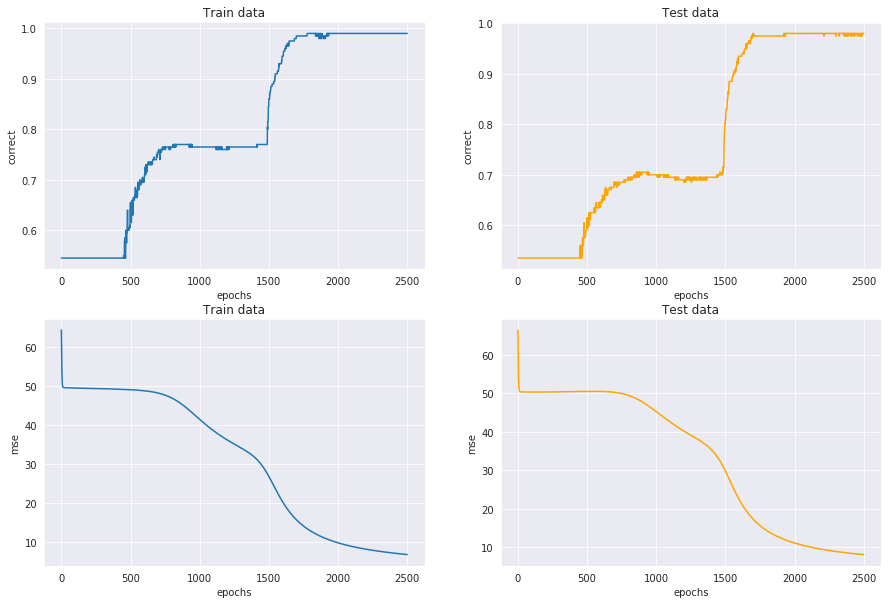

In [9]:
plot_stats(accuracys_test, mses_test, accuracys_train, mses_train)

### 2.4) Darstellung des 100x100 Gitters mit trainiertem Modeloutput

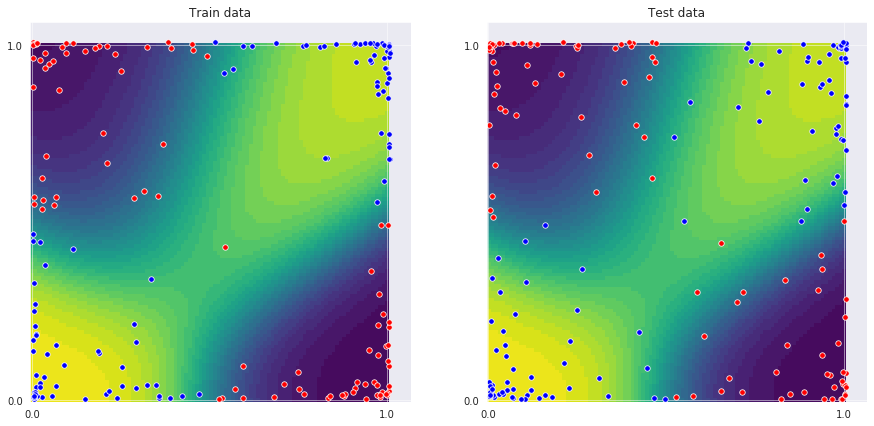

In [10]:
values = get_grid(x0, x2, weights, biases)
plot_grid(x0, y0, x2, y2, values)

## 3) Nachvollziehen der Beispiele aus der Vorlesung

In [11]:
global activation_method
global cost_method
activation_method = "TANH"
cost_method = "MSE"

accuracys_test, mses_test, accuracys_train, mses_train, biases, weights = SGD(x0, y0, n_epochs, mbs, eta, x2, y2, split, layer_dims)

Epoch: 0 / 2500, Train-Accuracy: 0.5450(54.50%), Test-Accuracy: 0.5350(53.50%)
Epoch: 100 / 2500, Train-Accuracy: 0.7800(78.00%), Test-Accuracy: 0.7400(74.00%)
Epoch: 200 / 2500, Train-Accuracy: 0.7400(74.00%), Test-Accuracy: 0.7250(72.50%)
Epoch: 300 / 2500, Train-Accuracy: 0.8000(80.00%), Test-Accuracy: 0.7550(75.50%)
Epoch: 400 / 2500, Train-Accuracy: 0.7900(79.00%), Test-Accuracy: 0.7650(76.50%)
Epoch: 500 / 2500, Train-Accuracy: 0.8300(83.00%), Test-Accuracy: 0.8150(81.50%)
Epoch: 600 / 2500, Train-Accuracy: 0.7900(79.00%), Test-Accuracy: 0.7850(78.50%)
Epoch: 700 / 2500, Train-Accuracy: 0.7450(74.50%), Test-Accuracy: 0.7350(73.50%)
Epoch: 800 / 2500, Train-Accuracy: 0.8050(80.50%), Test-Accuracy: 0.8050(80.50%)
Epoch: 900 / 2500, Train-Accuracy: 0.7650(76.50%), Test-Accuracy: 0.7800(78.00%)
Epoch: 1000 / 2500, Train-Accuracy: 0.7650(76.50%), Test-Accuracy: 0.7750(77.50%)
Epoch: 1100 / 2500, Train-Accuracy: 0.7900(79.00%), Test-Accuracy: 0.8150(81.50%)
Epoch: 1200 / 2500, Train-Ac

### 3.3) Genauigkeit und MSE von Training und Test Daten

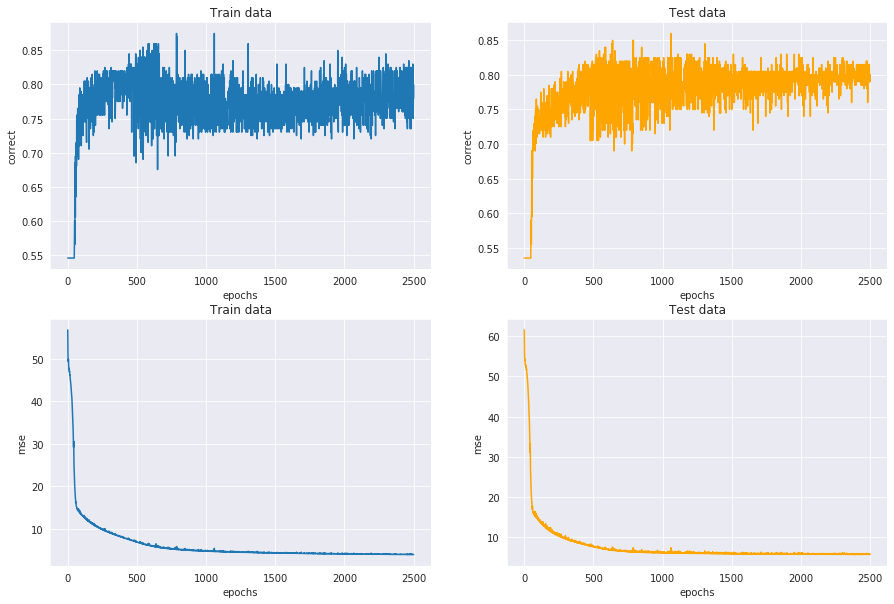

In [12]:
plot_stats(accuracys_test, mses_test, accuracys_train, mses_train)

### 3.4) Darstellung des 100x100 Gitters mit trainiertem Modeloutput

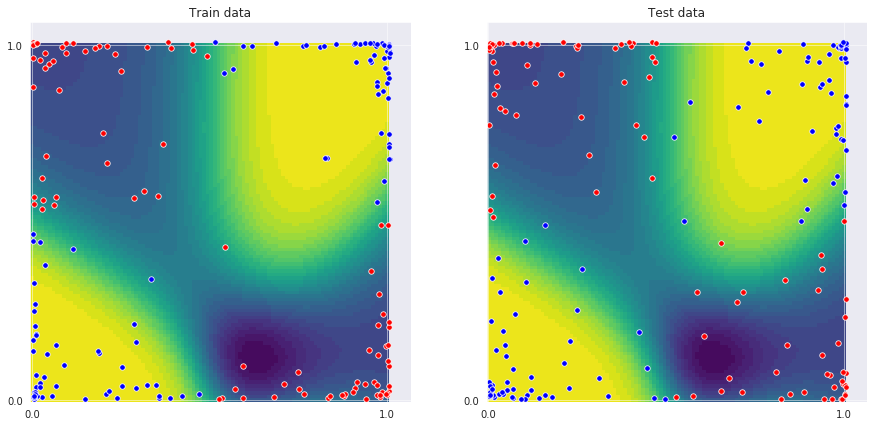

In [13]:
values = get_grid(x0, x2, weights, biases)
plot_grid(x0, y0, x2, y2, values)

## 4) Logistische Regression

In [14]:
global activation_method
global cost_method
activation_method = "SIGMOID"
cost_method = "LOGREG"

accuracys_test, mses_test, accuracys_train, mses_train, biases, weights = SGD(x0, y0, n_epochs, mbs, eta, x2, y2, split, layer_dims)

Epoch: 0 / 2500, Train-Accuracy: 0.5450(54.50%), Test-Accuracy: 0.5350(53.50%)
Epoch: 100 / 2500, Train-Accuracy: 0.5450(54.50%), Test-Accuracy: 0.5350(53.50%)
Epoch: 200 / 2500, Train-Accuracy: 0.6000(60.00%), Test-Accuracy: 0.5950(59.50%)
Epoch: 300 / 2500, Train-Accuracy: 0.9650(96.50%), Test-Accuracy: 0.9300(93.00%)
Epoch: 400 / 2500, Train-Accuracy: 0.9800(98.00%), Test-Accuracy: 0.9450(94.50%)
Epoch: 500 / 2500, Train-Accuracy: 0.9750(97.50%), Test-Accuracy: 0.9400(94.00%)
Epoch: 600 / 2500, Train-Accuracy: 0.9800(98.00%), Test-Accuracy: 0.9400(94.00%)
Epoch: 700 / 2500, Train-Accuracy: 0.9750(97.50%), Test-Accuracy: 0.9350(93.50%)
Epoch: 800 / 2500, Train-Accuracy: 0.9800(98.00%), Test-Accuracy: 0.9350(93.50%)
Epoch: 900 / 2500, Train-Accuracy: 0.9800(98.00%), Test-Accuracy: 0.9400(94.00%)
Epoch: 1000 / 2500, Train-Accuracy: 0.9800(98.00%), Test-Accuracy: 0.9400(94.00%)
Epoch: 1100 / 2500, Train-Accuracy: 0.9800(98.00%), Test-Accuracy: 0.9350(93.50%)
Epoch: 1200 / 2500, Train-Ac

### 4.3) Genauigkeit und MSE von Training und Test Daten

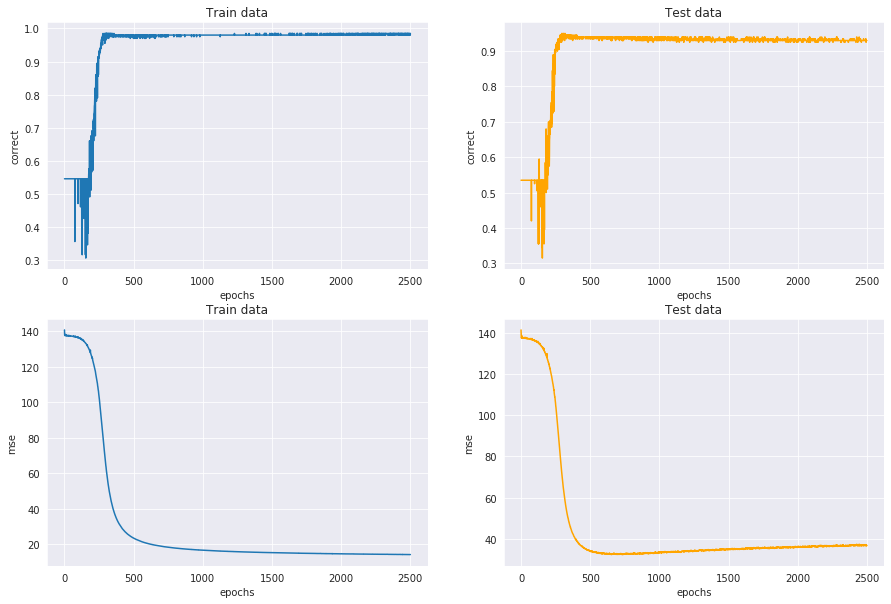

In [15]:
plot_stats(accuracys_test, mses_test, accuracys_train, mses_train)

### 4.4) Darstellung des 100x100 Gitters mit trainiertem Modeloutput

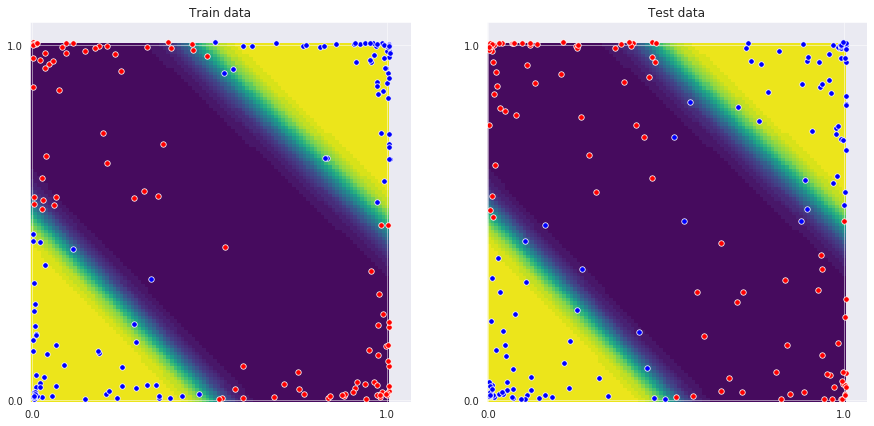

In [16]:
values = get_grid(x0, x2, weights, biases)
plot_grid(x0, y0, x2, y2, values)